# Create a raster mask using a shapefile

**What does this notebook do?** 

This notebook demonstrates how to use a shapefile to mask data extracted from DEA. This notebook imports some Landsat 8 data, generates a shapefile mask, and applies it to the extracted Landsat data.

**Requirements**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

* A shape file containing the polygon you would like to use for the analysis. Here we use the ACT reserves [shapefile from data.gov.au](http://actmapi-actgov.opendata.arcgis.com/datasets/df2194f3f13f4521a96c15a0faba04ee_11). Before you use this notebook, put your polygon somewhere accessible and update the cell with the `shape_file` = `path`.

This example uses two external functions called `three_band_image` and `load_nbarx`. These functions are available in the 10_Scripts folder of the [dea-notebooks Github repository](https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/10_Scripts). Note that these functions have been developed by DEA users, not the DEA development team, and so are provided without warranty. 

**Date:** August 2018

**Author:** Claire Krause

In [2]:
%pylab notebook

from datacube import Datacube

import xarray as xr
import rasterio
import rasterio.features
import geopandas as gp

# Import the custom scripts. These can be found in the dea-notebooks repository.
import sys
import os.path
sys.path.append(os.path.expanduser('~/dea-notebooks/10_Scripts'))
import DEAPlotting
import DEADataHandling

dc = Datacube(app='raster mask')

Populating the interactive namespace from numpy and matplotlib


## Set up the extraction query

In [3]:
query = {'lat': (-35.25, -35.35),
         'lon': (149.05, 149.17),
         'time': ('2016-01-01', '2016-03-01')
         }

In [4]:
data, crs, affine = DEADataHandling.load_nbarx(dc, 'ls8', query,
                                               bands_of_interest=['swir1', 'nir', 'green'])

Loading ls8_nbart_albers
Loaded ls8_nbart_albers
Generating mask ls8_pq_albers


## Read in the shapefile you would like to use to mask the Landsat data

For this example, we use the polygon dataset of [ACT Reserves](http://actmapi-actgov.opendata.arcgis.com/datasets/df2194f3f13f4521a96c15a0faba04ee_11). 

In [5]:
shape_file = os.path.expanduser('~/dea-notebooks/03_Integrating_external_data/Files/ACT_Reserves.shp')

In [6]:
shp = gp.read_file(shape_file)

# Reproject coordinate system of shape file
shp = shp.to_crs({'init': 'epsg:3577'})

### Iterate over each of the polygons, and put a '1' in the mask raster that corresponds to the footprint of each polygon

In [7]:
mask = rasterio.features.rasterize(((feature['geometry'], 1) for feature in shp.iterfeatures()),
                                   out_shape=data.isel(time=0).green.shape,
                                   transform=data.green.affine
                                  )

In [8]:
# Convert the numpy array to a DataArray
mask = xr.DataArray(mask, coords=(data.y, data.x))

<IPython.core.display.Javascript object>


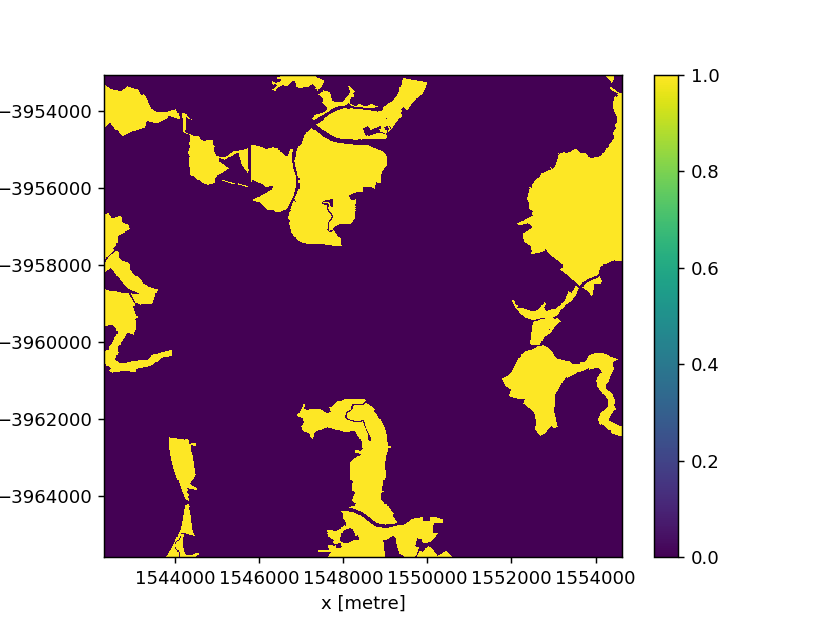

In [9]:
plt.figure()
mask.plot()

## Apply the mask to the Landsat data and plot

In [10]:
# Data * mask = data or nan
MaskedData = data.where(mask)

<IPython.core.display.Javascript object>


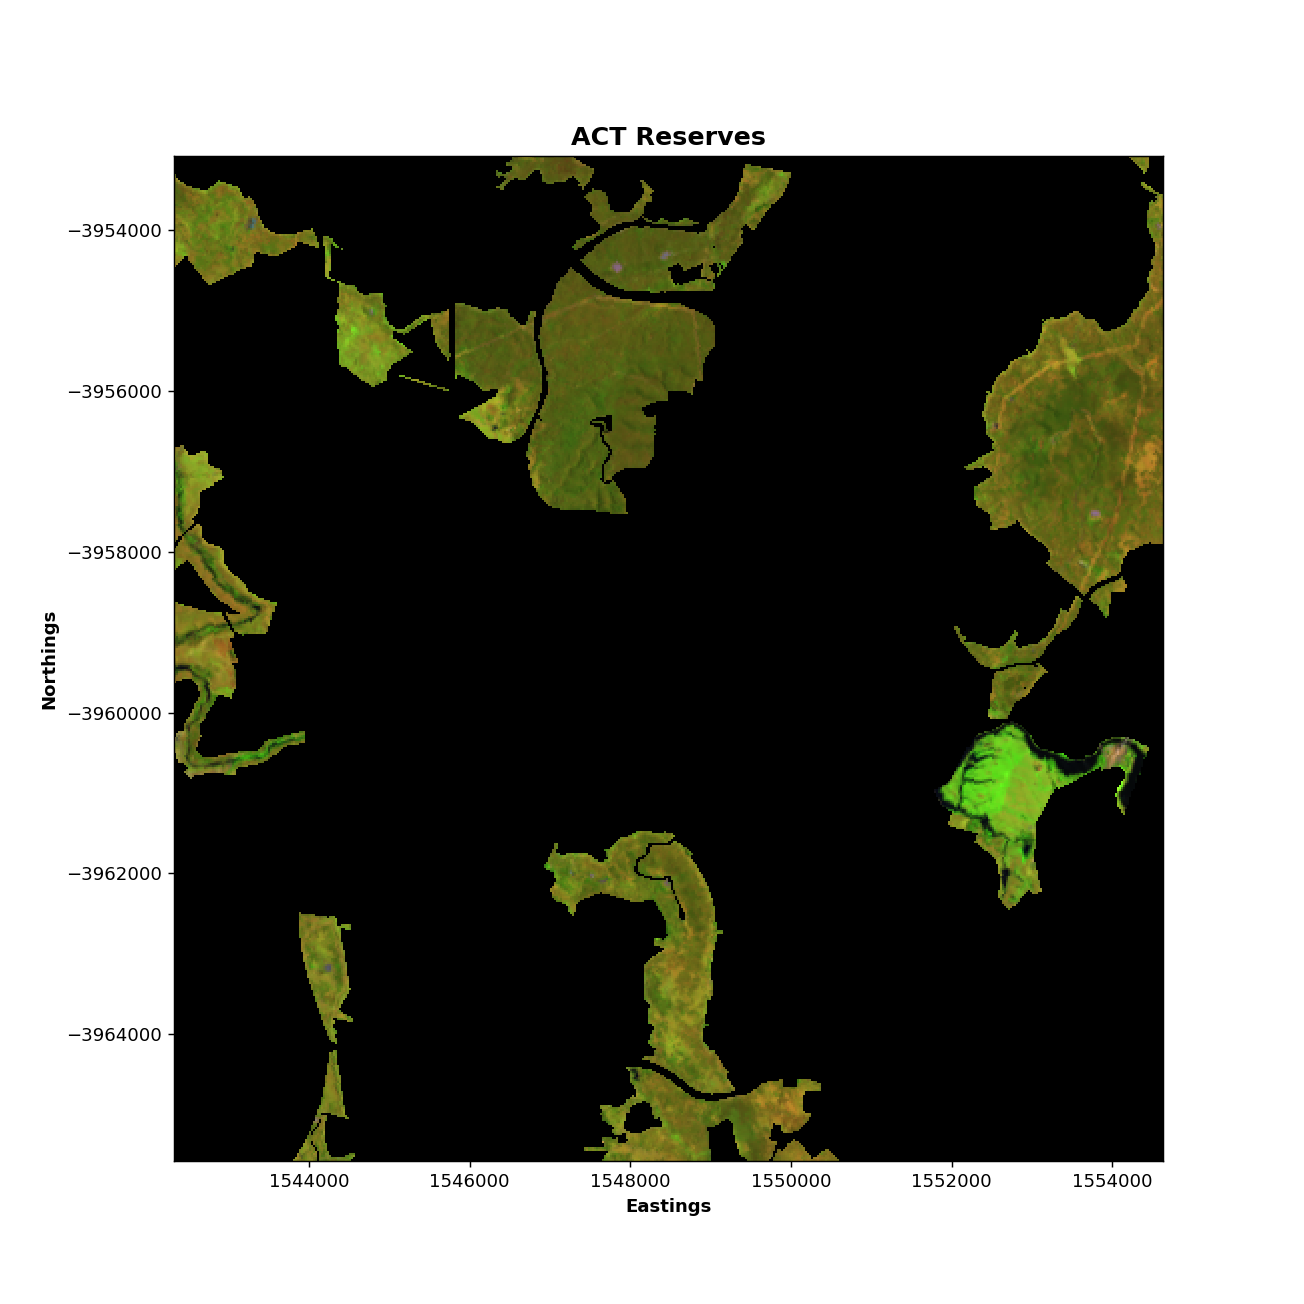

In [11]:
DEAPlotting.three_band_image(MaskedData, bands = ['swir1', 'nir', 'green'], time = 5, title = 'ACT Reserves');